In [1]:
# import libraries
import numpy as np
from keras.preprocessing import image
from keras.applications import Xception, VGG16, ResNet50
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import *
from keras.models import Model
from keras.models import Sequential, save_model, load_model

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 198817054719469602
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7018292839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11874699290240880943
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
# define the training directory with the images 
train_data_dir  = "../small_dataset/"

In [4]:
# do a bit of data science 
import pandas as pd 
import os

classnames = []
num_files = 0
distributions = {}

# loop through the directories and save the number of files of each type 
for subdir, dirs, files in os.walk(train_data_dir):
    directory = subdir.split("/")
    classname = directory[-1]
    classnames.append(classname)

    for file in files:
        num_files+=1
        #print(os.path.join(subdir, file))
        #print(subdir)
        #print(file)
    
    distributions[classname] = num_files
    num_files = 0
    
                  
distributions.pop("")
print(classnames)
print(len(classnames))
print(distributions)

['', 'alfalfa', 'allium', 'borage', 'calendula', 'chicory', 'chive_blossom', 'common_mallow', 'coneflower', 'cowslip', 'daffodil', 'garlic_mustard', 'geranium', 'henbit', 'mullein', 'red_clover']
16
{'alfalfa': 470, 'allium': 481, 'borage': 500, 'calendula': 500, 'chicory': 500, 'chive_blossom': 454, 'common_mallow': 439, 'coneflower': 500, 'cowslip': 521, 'daffodil': 80, 'garlic_mustard': 409, 'geranium': 500, 'henbit': 500, 'mullein': 500, 'red_clover': 449}


,0
alfalfa,470
allium,481
borage,500
calendula,500
chicory,500
chive_blossom,454
common_mallow,439
coneflower,500
cowslip,521
daffodil,80


array([<AxesSubplot:ylabel='0'>], dtype=object)

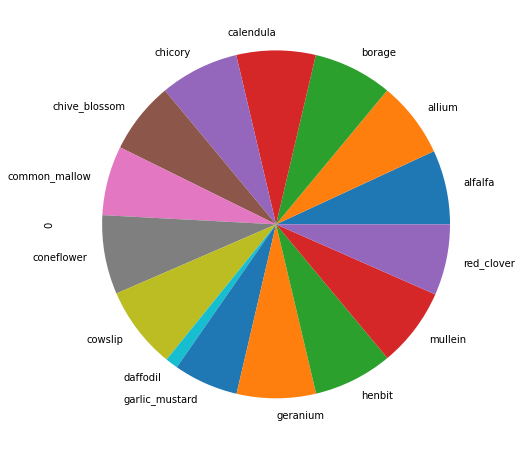

In [5]:
# Visualize the data distributions 
data = pd.DataFrame.from_dict(distributions, orient='index')
display(data)
data.plot.pie(subplots=True, figsize=(12, 8), legend=None)

In [6]:
# set the image size
img_height = 128
img_width = 128

In [7]:
# define some of the model parameters
batch_size = 32

In [8]:
# create an image data generator and apply data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,                   
    validation_split=0.2) # set validation split

# training generator 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical',
    subset='training') # set as training data

# validation generator 
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 5446 images belonging to 15 classes.
Found 1357 images belonging to 15 classes.


In [9]:
epochs = 100

train_filenames = train_generator.filenames
num_train_samples = len(train_filenames)
validation_filenames = validation_generator.filenames
num_val_samples = len(validation_filenames)

num_classes = 15

In [10]:
# define the model architecture, we perform transfer learning using the Xception model trained in colab
base_model = VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
#print(model.summary())

# Train the top layer of the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [12]:
# create the model checkpoints 
csv_logger = CSVLogger("logs/" + "VGG16_2" "_log.csv", append=True, separator=';')
early_stopping = EarlyStopping(monitor="accuracy", patience = 5)
LR_reducer = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3) #min_lr=0.001
model_checkpoint = ModelCheckpoint(filepath="VGG16_2.h5", monitor="val_loss", save_best_only=True) 

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[csv_logger, early_stopping, LR_reducer, model_checkpoint],
    validation_data=validation_generator,
    validation_steps= (num_val_samples // batch_size))

Epoch 1/100
170/170 [==============================] - 51s 299ms/step - loss: 1.7584 - accuracy: 0.4540 - val_loss: 1.1756 - val_accuracy: 0.5603
Epoch 2/100
170/170 [==============================] - 54s 315ms/step - loss: 1.1829 - accuracy: 0.6201 - val_loss: 1.5697 - val_accuracy: 0.6634
Epoch 3/100
170/170 [==============================] - 54s 318ms/step - loss: 1.0159 - accuracy: 0.6723 - val_loss: 1.6237 - val_accuracy: 0.6181
Epoch 4/100
170/170 [==============================] - 53s 314ms/step - loss: 0.9289 - accuracy: 0.6967 - val_loss: 0.8857 - val_accuracy: 0.6860
Epoch 5/100
170/170 [==============================] - 55s 322ms/step - loss: 0.8613 - accuracy: 0.7183 - val_loss: 0.5772 - val_accuracy: 0.7019
Epoch 6/100
170/170 [==============================] - 54s 315ms/step - loss: 0.8199 - accuracy: 0.7373 - val_loss: 0.9961 - val_accuracy: 0.7004
Epoch 7/100
170/170 [==============================] - 56s 332ms/step - loss: 0.8006 - accuracy: 0.7331 - val_loss: 1.0194 -

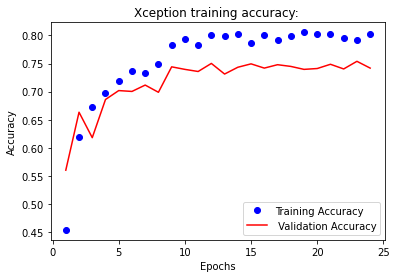

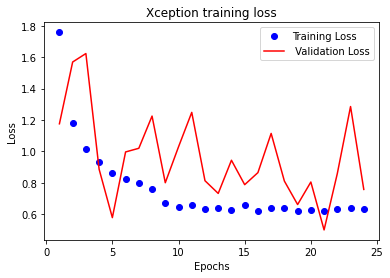

In [19]:
# Plot the training results
import matplotlib.pyplot as plt 

# Visualize the and accuracy loss during training 
history_dict = history.history

training_loss = history_dict["loss"]
training_accuracy = history_dict["accuracy"]

validation_accuracy = history_dict["val_accuracy"]
validation_loss = history_dict["val_loss"]

epochs = range(1, len(training_loss)+1) 

# Plot the train/val accuracy
plt.plot(epochs, training_accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, validation_accuracy, 'r', label=" Validation Accuracy")

plt.title("Xception training accuracy: ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.figure()

# Plot the train/val loss
plt.plot(epochs, training_loss, 'bo', label="Training Loss")
plt.plot(epochs, validation_loss, 'r', label=" Validation Loss")

plt.title("Xception training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
# import some additional librairies
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure

# calculate the predictions 
validation_generator.reset() 
probabilities = model.predict_generator(validation_generator)
y_true = validation_generator.classes 
y_pred = np.argmax(probabilities, axis=1)

In [21]:
print(y_pred)
print(y_true)

[ 0  3  8 ... 14  8  8]
[ 0  0  0 ... 14 14 14]


In [17]:
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(y_true, y_pred))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.07      0.07      0.07        94
           1       0.05      0.04      0.05        96
           2       0.08      0.08      0.08       100
           3       0.08      0.08      0.08       100
           4       0.11      0.11      0.11       100
           5       0.03      0.03      0.03        90
           6       0.10      0.08      0.09        87
           7       0.06      0.06      0.06       100
           8       0.11      0.12      0.12       104
           9       0.00      0.00      0.00        16
          10       0.03      0.04      0.04        81
          11       0.09      0.10      0.10       100
          12       0.09      0.09      0.09       100
          13       0.06      0.06      0.06       100
          14       0.11      0.09      0.10        89

    accuracy                           0.08      1357
   macro avg       0.07      0.07      0.07      13

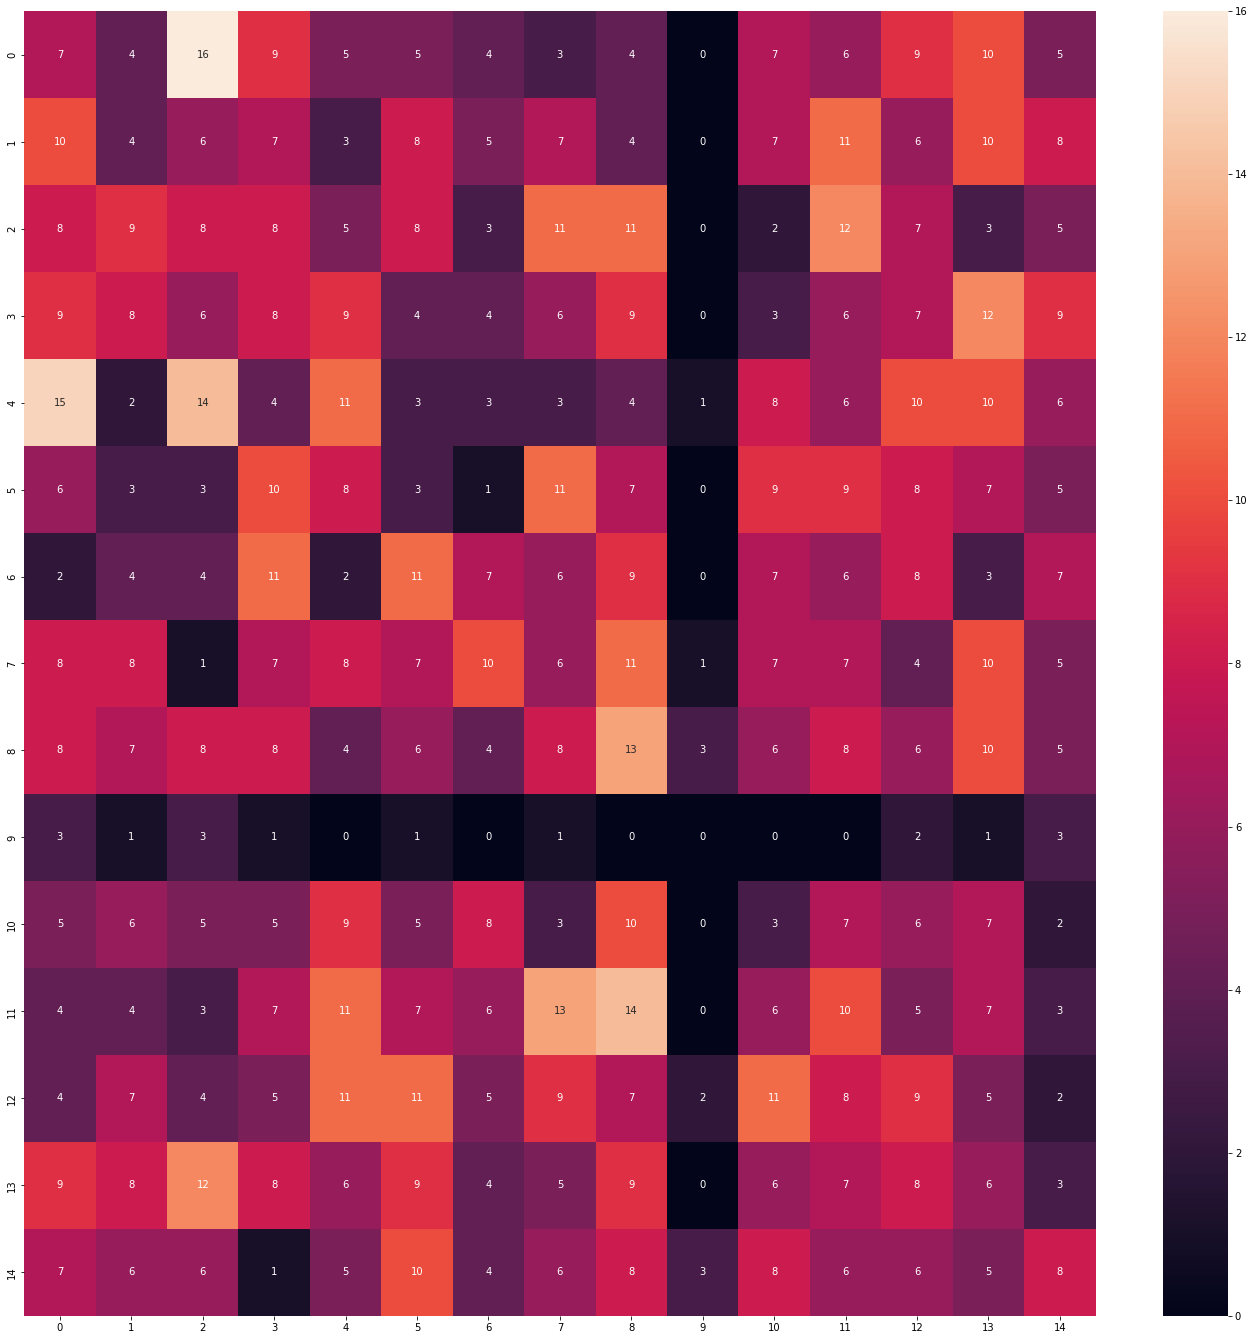

In [18]:
# plot the confusion matrix
import seaborn as sns 
figure(figsize=(24, 24))
cm = confusion_matrix(y_true, y_pred)
disp = sns.heatmap(cm, annot=True)
disp.plot(cmap=plt.cm.Blues)
#disp.ax_.set_title("Confusion Matrix for Xception Model")
plt.show()